In [22]:
# Recap on autoencoders for MNIST dataset
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.utils.data import Dataset
import torchvision

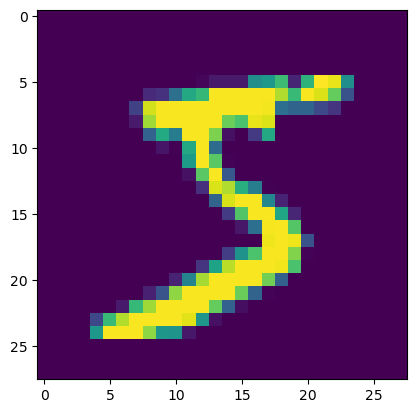

In [62]:
mndata = 'C:\\Users\\thopa\\Desktop\\Assignments\\11685\\Revision\\Part2_Recap\\MNIST_Autoencoder\\samples\\'
train_images = 'train-images-idx3-ubyte.gz'
train_labels = 'train-labels-idx1-ubyte.gz'
# test_images = 
# test_labels = 
train_img = gzip.open(mndata+ train_images,'r')
train_labels = gzip.open(mndata + train_labels,'r')
image_size = 28
num_images = 1

train_img.read(16)
buf = train_img.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)
image = np.asarray(data).squeeze()/ 255.0
plt.imshow(image)
plt.show()

In [130]:


train_dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
batch_size_train = len(train_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
batch_size_test = len(test_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset,
  batch_size=batch_size_test, shuffle=True)
print("train samples: {} | test samples {}".format(len(train_dataset), len(test_dataset)))

train samples: 60000 | test samples 10000


torch.Size([60000, 784])


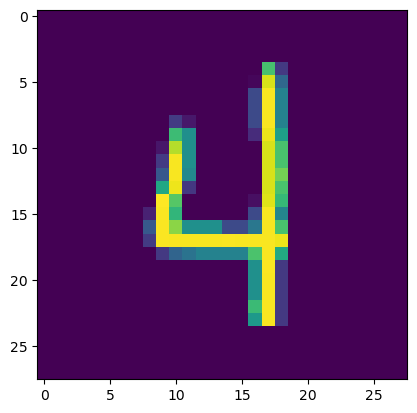

In [68]:
a,b = train_dataset.__getitem__(0)
a.shape
for i, (data, label) in enumerate(train_loader):
    data = np.squeeze(data).reshape(60000,784)
    print(data.shape)
    data = data[0].reshape(image_size, image_size)

    plt.imshow(data)
    plt.show()
    
    break


In [102]:
class simpleAutoEncoder(nn.Module):
    def __init__(self, size):
        super(simpleAutoEncoder, self).__init__()

        # Input size = 28*28 ~ 784
        self.encoder = nn.Sequential(nn.Linear(size[0], size[1]),nn.ReLU())
        self.latent1 = nn.Linear(size[1], size[2])
        self.act1 = nn.ReLU()
        self.latent2 = nn.Sequential(nn.Linear(size[2], size[3]), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(size[3],size[4]), nn.Sigmoid())


    
    def forward(self, x):
        x = self.encoder(x)
        x = self.latent1(x)
        x = self.act1(x)
        x = self.latent2(x)
        x = self.decoder(x)
       
         
        return x
    


In [103]:
input_size = 784
hidden_size = 128
code_size = 32

size_mat = [input_size, hidden_size, code_size, hidden_size, input_size]  
model = simpleAutoEncoder(size_mat)
model.cuda()
device = "cuda"

In [119]:
# Loss optimizers and schedulers 
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, )
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:

epochs = 923

checkpoint = torch.load("C:\\Users\\thopa\\Desktop\\Assignments\\11685\\Revision\\Part2_Recap\\MNIST_Autoencoder\\model_ckpt\\epoch_590.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
current_epoch = checkpoint['epoch']
train_loss = checkpoint['loss']


model.train()
for i in range(current_epoch, epochs):
    optimizer.zero_grad()
    for j, (data, labels) in enumerate(train_loader):
        data = np.squeeze(data).reshape(60000,784)
        data = data.to(device)
        out = model(data)
        crit = loss(out, data)
        crit.backward()
        optimizer.step()
        print("[EPOCH : {}] Train Loss: {}".format(i , crit.item()))
    scheduler.step(crit.item())
    if i % 10 == 0:
        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': crit.item(),
            },"C:\\Users\\thopa\\Desktop\\Assignments\\11685\\Revision\\Part2_Recap\\MNIST_Autoencoder\\model_ckpt\\epoch_{}.pt".format(i))


In [134]:
# Model Evaluate perceptually ~ Observing 5 samples 
# Average test loss as well with BATCH gradient descent 

for i, (test_data, test_labels) in  enumerate(test_loader):
    model = model.eval()
    test_data = test_data.reshape(10000,784)
    test_data = test_data.to(device)
    out = model(test_data)
    
    crit = loss(out, test_data)
    print("average test loss: {}".format(crit.item()))

# plotting few of the reconstructed images 
out = out.detach().cpu().numpy()
test_data = test_data.cpu().numpy()


average test loss: 0.5307731032371521
(10000, 784)
(10000, 784)


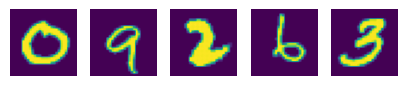

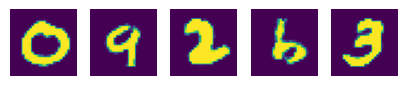

In [152]:

predicted = np.asarray(out[0:5].reshape(5, image_size, image_size, 1)).squeeze()
original  = np.asarray(test_data[0:5].reshape(5,image_size, image_size,1)).squeeze()

fig = plt.figure(figsize=(5, 7))
for i in range(5):
    fig.add_subplot(2, 5, i+1)
    data = original[i].reshape(image_size, image_size)
    plt.imshow(data)
    plt.axis("off")

fig = plt.figure(figsize=(5, 7))
for i in range(5):
    fig.add_subplot(2, 5, i+1)
    data = predicted[i].reshape(image_size, image_size)
    plt.imshow(data)
    plt.axis("off")

